### Module

In [1]:
#VAE
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import time

#HDP-GP-HSMM
import random
import math
import sys
import os
import glob

In [2]:
print (tf.__version__)

2.4.1


### VAE

In [3]:
class Variational_Auto_Encoder():
  def __init__(self, input_dim, hidden_dims, latent_dim, kld_weight, epochs):
    self.input_dim = input_dim
    self.latent_dim = latent_dim
    self.hidden_encoder_dim1 = hidden_dims[0]
    self.hidden_encoder_dim2 = hidden_dims[1]
    self.hidden_decoder_dim1 = hidden_dims[2]
    self.hidden_decoder_dim2 = hidden_dims[3]
    self.kld_weight = kld_weight
    self.opt = Adam(lr=0.0001)
    self.epochs = epochs

    #encoder
    logvar_prior = tf.keras.Input(shape=(self.latent_dim, ), name='logvar_prior')
    mu_prior = tf.keras.Input(shape=(self.latent_dim, ), name='mu_prior')
    inputs = tf.keras.layers.Input(shape=(self.input_dim, ), name='encoder_input')
    hidden1= tf.keras.layers.Dense(self.hidden_encoder_dim1, activation='relu', name='enc1') (inputs)
    hidden2 = tf.keras.layers.Dense(self.hidden_encoder_dim2, activation='relu', name='enc2') (hidden1)
    z_mean = tf.keras.layers.Dense(self.latent_dim, activation='linear', name='z_mean')(hidden2)
    z_log_var= tf.keras.layers.Dense(self.latent_dim, activation='linear', name='z_log_var')(hidden2)
    z = tf.keras.layers.Lambda(self.sampling, name='z')([z_mean, z_log_var])
    
    enc_outputs = [z_mean, z_log_var, z]
    encoder = tf.keras.models.Model(inputs, enc_outputs, name='encoder')

    #decoder
    latent_inputs = tf.keras.layers.Input(shape=(self.latent_dim,), name='z_sampling')
    dec_hidden1 = tf.keras.layers.Dense(self.hidden_decoder_dim1, activation='relu', name='dec1') (latent_inputs)
    dec_hidden2 = tf.keras.layers.Dense(self.hidden_decoder_dim2, activation='relu', name='dec2') (dec_hidden1)
    outputs = tf.keras.layers.Dense(self.input_dim, activation='sigmoid') (dec_hidden2)

    decoder = tf.keras.models.Model(latent_inputs, outputs, name='decoder')

    #VAE(encoder+decoder)
    inputs_ = [inputs, logvar_prior, mu_prior]
    outputs_ = [ decoder(encoder(inputs)[2]), encoder(inputs)[0], encoder(inputs)[1] , encoder(inputs)[2]]  #output, mu, sigma
    self.VAE = tf.keras.models.Model(inputs_, outputs_, name='VAE')
    
    #Loss
    MSE = tf.reduce_sum( tf.math.squared_difference(K.flatten(outputs_[0]), K.flatten(inputs_[0])))
    KLD = - 0.5 * tf.reduce_sum(1 + logvar_prior + z_log_var
            - (tf.pow(z_mean - mu_prior, 2) 
            + tf.exp(z_log_var))/tf.exp(logvar_prior))
    loss = tf.reduce_mean(MSE + KLD * self.kld_weight )

    self.VAE.add_loss(loss)

  def sampling(self, args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

  def compile(self):
    self.VAE.compile(optimizer=self.opt)
    #print (self.VAE.summary())

  def learn(self, data, logvar_prior, mu_prior, verbose=True):
    result = self.VAE.fit([data, logvar_prior, mu_prior] , epochs=1, verbose=verbose)
    return result

  def predict(self, data, logvar_prior, mu_prior, losses=False):
    reconst, mu, sigma, z = self.VAE.predict([data, logvar_prior, mu_prior])
    return reconst, mu, sigma, z

  def plot(self, data, reconst, mu, sigma, z, losses, savepath):
    if losses != False:
      plt.title('loss')
      plt.plot(np.arange(self.epochs), losses)
      plt.savefig(savepath+'_loss.png')
      plt.close()

    plt.title("z_alldim")
    plt.plot(np.arange(mu.shape[0]), mu)
    plt.savefig(savepath+'_z.png')
    plt.close()

    plt.title("z_hat_alldim")
    plt.plot(np.arange(mu.shape[0]), z)
    plt.savefig(savepath+'_z_hat.png')
    plt.close()

    plt.title('data_alldim')
    plt.plot(np.arange(mu.shape[0]), data)
    plt.savefig(savepath+'_oridata.png')
    plt.close()

    plt.title('reconst_alldim')
    plt.plot(np.arange(mu.shape[0]), reconst)
    plt.savefig(savepath+'_reconst.png')
    plt.close()

### GaussianProcess

In [4]:
%load_ext Cython

In [5]:
%%cython
import numpy as np
import random
import matplotlib.pyplot as plt

cdef extern from "math.h":
    double exp(double)
    double sqrt(double)
    double log(double)

cdef class GP:
    cdef double beta
    cdef int ns
    cdef xt, yt
    cdef double[:,:] i_cov
    cdef double[:] param
    cdef dict param_cache

    cdef double covariance_func(self, double xi, double xj):
        cdef double theta0 = 1.0
        cdef double theta1 = 1.0
        cdef double theta2 = 0
        cdef double theta3 = 16.0
        return theta0 * exp(-0.5 * theta1 * (xi - xj) * (xi - xj)) + theta2 + theta3 * xi * xj
    
    cdef double normpdf(self, double x, double mu, double sigma):
        return 1./(sqrt(2*np.pi)*sigma)*exp(-0.5 * ((x - mu)/sigma)**2)

    def __init__( self ):
        self.beta = 10.0
        self.param_cache = {}

    def learn(self, xt, yt ):
        cdef int i, j
        self.xt = xt
        self.yt = yt
        self.ns = len(xt)

        cdef double[:,:] cov = np.zeros((self.ns, self.ns))

        for i in range(self.ns):
            for j in range(self.ns):
                cov[i,j] = self.covariance_func(xt[i], xt[j])
                if i==j:
                    cov[i,j] += 1/self.beta

        self.i_cov = np.linalg.inv(cov)
        self.param = np.dot(self.i_cov, self.yt)
        self.param_cache.clear()

    def plot(self, x):
        mus, sigmas = self.predict( x.reshape(-1,1) )
        plt.plot( x, mus )
        
        y_max = mus + np.sqrt(sigmas.flatten())
        y_min = mus - np.sqrt(sigmas.flatten())

        plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )
        plt.plot(self.xt, self.yt)
        plt.show()


    def predict( self, x ):
        mus = []
        sigmas = []
        n = len(x)
        tt = [y - np.random.normal() / self.beta for y in self.yt]
        for k in range(n):
            v = np.zeros((self.ns))
            for i in range(self.ns):
                v[i] = self.covariance_func(x[k], self.xt[i])
            c = self.covariance_func(x[k], x[k]) + 1.0 / self.beta
            
            mu = np.dot(v, np.dot(self.i_cov, tt))
            sigma = c - np.dot(v, np.dot(self.i_cov, v))
            
            mus.append(mu)
            sigmas.append(sigma)
        
        return np.array(mus), np.array(sigmas)
    

    cpdef double calc_lik_al( self, double[:] xs, double[:] ys ):
        cdef int k,i
        cdef int n = len(xs)
        cdef double lik = 0
        cdef int ns = self.ns
        cdef double c,p,mu,sigma
        cdef double[:] v= np.zeros((ns))

        for k in range(n):
            # 計算結果をキャッシュして使い回す
            if xs[k] in self.param_cache:
                mu, sigma = self.param_cache[ xs[k] ]
            else:
                v = np.zeros((ns))
                for i in range(ns):
                    v[i] = self.covariance_func(xs[k], self.xt[i])
                c = self.covariance_func(xs[k], xs[k]) + 1.0 / self.beta
                mu = np.dot(v, self.param)
                sigma = c - np.dot(v, np.dot(self.i_cov, v))
                
                self.param_cache[ xs[k] ] = (mu, sigma)

            p = self.normpdf( ys[k] , mu, sigma )
            if p<=0:
                p = 0.000000000001
            lik += log( p )

        return lik


    def calc_lik( self, xs, ys ):
      lik = self.calc_lik_al( xs, ys )
      return lik

### logsum

In [6]:
%%cython
import numpy as np
import random
import matplotlib.mlab as mlab
import sys

cdef extern from "math.h":
    double log(double)
    double exp(double)


cpdef logsumexp( double[:,:] a ):
    cdef double max_val = -sys.float_info.max
    cdef double sum_exp = 0
    cdef int I = a.shape[0]
    cdef int J = a.shape[1]
    
    for i in range(I):
        for j in range(J):
            if max_val<a[i,j]:
                max_val = a[i,j]
                
    for i in range(I):
        for j in range(J):
            sum_exp += exp( a[i,j] - max_val )
    return log(sum_exp) + max_val

### multidim

In [7]:
class GPMD:
    def __init__(self, dim):
        self.__dim = dim
        self.__gp = [ GP() for d in range(self.__dim) ]

    def learn(self,x, y ):
        y = np.array(y, dtype=np.float).reshape( (-1,self.__dim) )
        x = np.array(x,dtype=np.float)

        for d in range(self.__dim):
            if len(y)!=0:
                self.__gp[d].learn( x, y[:,d] )
            else:
                self.__gp[d].learn( x, [] )


    def calc_lik(self, x, y, last = False):
        lik = 0.0
        mus = []
        sigmas = []

        if self.__dim==1:
            y = np.asarray(y, dtype=np.float).reshape( (-1,self.__dim) )
        for d in range(self.__dim):
            lik += self.__gp[d].calc_lik( x , y[:,d] )
            if last != False:
              mu , sig = self.__gp[d].predict(x)
              mus.append(mu)
              sigmas.append(sig)

        if last != False:
          return lik, np.array(mus), np.array(sigmas)
        else:
          return lik

    def plot(self, x ):
        for d in range(self.__dim):
            plt.subplot( self.__dim, 1, d+1 )

            mus, sigmas = self.__gp[d].predict(x)
            y_min = mus - sigmas*2
            y_max = mus + sigmas*2

            plt.fill_between( x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )
            plt.plot(x, y_min, 'b--')
            plt.plot(x, mus, 'b-')
            plt.plot(x, y_max, 'b--')

### segmentation

In [8]:
class GPSegmentation():
    def __init__(self, dim, gamma, alpha, initial_class):
        self.dim = dim
        self.numclass = initial_class
        self.segmlen = 3
        self.gps = [ GPMD(dim) for i in range(self.numclass) ]
        self.segm_in_class= [ [] for i in range(self.numclass) ]
        self.segmclass = {}
        self.segments = []
        self.trans_prob = np.ones( (1,1) )
        self.trans_prob_bos = np.ones( 1 )
        self.trans_prob_eos = np.ones( 1 )
        self.all_numclass = []
        self.counter = 0
        self.is_initialized = False
        
        # parameters
        self.MAX_LEN = 20
        self.MIN_LEN = 3
        self.AVE_LEN = 12
        self.SKIP_LEN = 1

        self.alpha = alpha
        self.beta = np.ones(1)
        self.gamma = gamma

    def load_data(self, zs, classfile=None ):
        self.data = []
        self.segments = []
        self.is_initialized = False

        for y in zs:
            segm = []
            self.data.append( np.array(y, dtype=np.float) )

            i = 0
            while i<len(y):
                length = random.randint(self.MIN_LEN, self.MAX_LEN)

                if i+length+1>=len(y):
                    length = len(y)-i

                segm.append( y[i:i+length+1] )

                i+=length

            self.segments.append( segm )

            for i,s in enumerate(segm):
                c = random.randint(0,self.numclass-1)
                self.segmclass[id(s) ] = c

        self.calc_trans_prob()


    def load_model( self, basename ):
        for c in range(self.numclass):
            filename = basename + "class%03d.npy" % c
            self.segm_in_class[c] = np.load( filename, allow_pickle=True)
            self.update_gp( c )

        self.trans_prob = np.load( basename+"trans.npy", allow_pickle=True )
        self.trans_prob_bos = np.load( basename+"trans_bos.npy", allow_pickle=True )
        self.trans_prob_eos = np.load( basename+"trans_eos.npy", allow_pickle=True )


    def update_gp(self, c ):
        datay = []
        datax = []
        for s in self.segm_in_class[c]:
            datay += [ y for y in s ]
            datax += range(len(s))

        self.gps[c].learn( datax, datay )


    def calc_emission_logprob( self, c, segm ):
        gp = self.gps[c]
        slen = len(segm)

        if len(segm) > 2:
            log_plen = (slen*math.log(self.AVE_LEN) + (-self.AVE_LEN)*math.log(math.e)) - (sum(np.log(np.arange(1,slen+1))))
            p = gp.calc_lik( np.arange(len(segm), dtype=np.float) , segm )
            return p + log_plen
        else:
            return math.log(1.0e-100)

    def save_model(self, basename ):
        if not os.path.exists(basename):
            os.mkdir( basename )

        for n,segm in enumerate(self.segments):
            classes = []
            cut_points = []
            for s in segm:
                c = self.segmclass[id(s)]
                classes += [ c for i in range(len(s)) ]
                cut_points += [0] * len(s)
                cut_points[-1] = 1
            np.savetxt( basename+"segm%03d.txt" % n, np.vstack([classes,cut_points]).T, fmt=str("%d") )

        for c in range(len(self.gps)):
            for d in range(self.dim):
                plt.clf()
                for data in self.segm_in_class[c]:
                    if self.dim==1:
                        plt.plot( range(len(data)), data, "o-" )
                    else:
                        plt.plot( range(len(data[:,d])), data[:,d], "o-" )
                    plt.ylim( -1, 1 )
                plt.savefig( basename+"class%03d_dim%03d.png" % (c, d) )
                plt.close()

        np.save( basename + "trans.npy" , self.trans_prob  )
        np.save( basename + "trans_bos.npy" , self.trans_prob_bos )
        np.save( basename + "trans_eos.npy" , self.trans_prob_eos )
        np.save( basename + "all_class.npy", self.segm_in_class[c])

        for c in range(self.numclass):
            np.save( basename+"class%03d.npy" % c, self.segm_in_class[c] )

        return self.numclass


    def forward_filtering(self, d ):
        T = len(d)
        log_a = np.log( np.zeros( (len(d), self.MAX_LEN, self.numclass) )  + 1.0e-100 ) 
        valid = np.zeros( (len(d), self.MAX_LEN, self.numclass) ) 
        z = np.ones( T )

        for t in range(T):
            for k in range(self.MIN_LEN,self.MAX_LEN,self.SKIP_LEN):
                if t-k<0:
                    break

                segm = d[t-k:t+1]
                for c in range(self.numclass):
                    out_prob = self.calc_emission_logprob( c, segm )
                    foward_prob = 0.0

                    tt = t-k-1
                    if tt>=0:
                        foward_prob = logsumexp( log_a[tt,:,:] + z[tt] + np.log(self.trans_prob[:,c]) ) + out_prob
                    else:
                        foward_prob = out_prob + math.log(self.trans_prob_bos[c])

                    if t==T-1:
                        foward_prob += math.log(self.trans_prob_eos[c])

                    log_a[t,k,c] = foward_prob
                    valid[t,k,c] = 1.0
                    if math.isnan(foward_prob):
                        print( "a[t=%d,k=%d,c=%d] became NAN!!" % (t,k,c) )
                        sys.exit(-1)

            if t-self.MIN_LEN>=0:
                z[t] = logsumexp( log_a[t,:,:] )
                log_a[t,:,:] -= z[t]

        return np.exp(log_a)*valid


    def sample_idx(self, prob ):
        accm_prob = [0,] * len(prob)
        for i in range(len(prob)):
            accm_prob[i] = prob[i] + accm_prob[i-1]

        rnd = random.random() * accm_prob[-1]
        for i in range(len(prob)):
            if rnd <= accm_prob[i]:
                return i


    def backward_sampling(self, a, d):
        T = a.shape[0]
        t = T-1

        segm = []
        segm_class = []

        c = -1
        while True:
            if t==T-1:
                transp = self.trans_prob_eos
            else:
                transp = self.trans_prob[:,c]
            
            idx = self.sample_idx( (a[t]*transp).reshape( self.MAX_LEN*self.numclass ))

            k = int(idx/self.numclass)
            c = idx % self.numclass

            if t-k-1<=0:
                s = d[0:t+1]
            else:
                s = d[t-k:t+1]

            segm.insert( 0, s )
            segm_class.insert( 0, c )

            t = t-k-1

            if t<=0:
                break

        return segm, segm_class


    def calc_trans_prob( self ):
        self.trans_prob = np.zeros( (self.numclass,self.numclass) )
        self.trans_prob_bos = np.zeros( self.numclass )
        self.trans_prob_eos = np.zeros( self.numclass )

        for n,segm in enumerate(self.segments):
            if id(segm[0]) in self.segmclass:
                c_begin = self.segmclass[ id(segm[0]) ]
                self.trans_prob_bos[c_begin]+=1

            if id(segm[-1]) in self.segmclass:
                c_end = self.segmclass[ id(segm[-1]) ]
                self.trans_prob_eos[c_end]+=1

            for i in range(1,len(segm)):
                try:
                    cc = self.segmclass[ id(segm[i-1]) ]
                    c = self.segmclass[ id(segm[i]) ]
                except KeyError:

                    continue
                self.trans_prob[cc,c] += 1

        self.trans_prob_bos += self.alpha * self.beta
        self.trans_prob_eos += self.alpha * self.beta

        for c in range(self.numclass):
            self.trans_prob[c,:] += self.alpha * self.beta

        self.trans_prob = self.trans_prob / self.trans_prob.sum(1).reshape(self.numclass,1)
        self.trans_prob_bos = self.trans_prob_bos / np.sum( self.trans_prob_bos )
        self.trans_prob_eos = self.trans_prob_eos / np.sum( self.trans_prob_eos )


    def sample_num_states(self):

        # calculate u
        u = []
        for n,segm in enumerate(self.segments):
            c = self.segmclass[ id(segm[0]) ]
            p = self.trans_prob_bos[c]
            u.append( random.random() * p )

            c = self.segmclass[ id(segm[-1]) ]
            p = self.trans_prob_eos[c]
            u.append( random.random() * p )

            for i in range(1,len(segm)):
                cc = self.segmclass[ id(segm[i-1]) ]
                c = self.segmclass[ id(segm[i]) ]
                p = self.trans_prob[cc,c]
                u.append( random.random() * p )

        # remove 
        beta = list( self.beta )
        for c in range(self.numclass)[::-1]:
            if len(self.segm_in_class[c])==0:
                self.numclass -= 1
                self.gps.pop()
                self.segm_in_class.pop()
                beta[-2] += beta[-1]
                beta.pop()
                #print ("pop!")
            else:
                break

        u_min = np.min( u )

        N = 0
        for c in range(self.numclass):
            N += len(self.segm_in_class[c])

        while self.alpha*beta[-1]/N > u_min:
            stick_len = beta[-1]
            rnd = np.random.beta(1,self.gamma)
            beta[-1] = stick_len * rnd
            beta.append( stick_len * (1-rnd) )
            self.numclass += 1
            self.gps.append( GPMD(self.dim) )
            self.segm_in_class.append([])

        self.beta = np.array( beta )

        self.all_numclass.append(self.numclass)
    
    
    # If list.remove( elem ), ValueError.
    def remove_ndarray(self, lst, elem ):
        l = len(elem)
        for i,e in enumerate(lst):
            if len(e)!=l:
                continue
            if (e==elem).all():
                lst.pop(i)
                return
        raise ValueError( "ndarray is not found!!" )

    def learn(self):
        if self.is_initialized==False:
            # learn GP
            for i in range(len(self.segments)):
                for s in self.segments[i]:
                    c = self.segmclass[id(s)]
                    self.segm_in_class[c].append( s )

            # learn each classes
            for c in range(self.numclass):
                self.update_gp( c )

            self.is_initialized = True

        self.update(True)

    def recog(self):
        self.update(False)

    def update(self, learning_phase=True ):

        for i in range(len(self.segments)):
            if learning_phase:
                print ("slice sampling")
                self.sample_num_states()
            
            d = self.data[i]
            segm = self.segments[i]

            for s in segm:
                c = self.segmclass[id(s)]
                self.segmclass.pop( id(s) )

                if learning_phase:
                    # update parameter
                    self.remove_ndarray( self.segm_in_class[c], s )

            if learning_phase:
                # update GP
                for c in range(self.numclass):
                    self.update_gp( c )

                # update transition probability
                self.calc_trans_prob()

            start = time.clock()
            print( "forward...", end="")
            a = self.forward_filtering( d )

            print( "backward...", end="" )
            segm, segm_class = self.backward_sampling( a, d )
            print( time.clock()-start, "sec" )

            print( "Number of classified segments: [", end="")
            for s in self.segm_in_class:
                print( len(s), end=" " )
            print( "]" )


            self.segments[i] = segm

            for s,c in zip( segm, segm_class ):
                self.segmclass[id(s)] = c

                # update parameter
                if learning_phase:
                    self.segm_in_class[c].append(s)

            if learning_phase:
                # update GP
                for c in range(self.numclass):
                    self.update_gp( c )

                # update transition probability
                self.calc_trans_prob()
        return


    def calc_lik(self, last=False):
        liks = 0
        mus_all = []
        sigmas_all = []

        for segm in self.segments:
            # last
            if last != False:
              mus = [[] for i in range(self.dim)]
              sigmas = [[] for i in range(self.dim)]

            for n, s in enumerate(segm):
                c = self.segmclass[id(s)]
                liks += self.gps[c].calc_lik( np.arange(len(s),dtype=np.float) , np.array(s) )
                
                # last
                if last != False:
                  lik, mu, sig = self.gps[c].calc_lik( np.arange(len(s), dtype=np.float) , s , last)
                  if n == 0:
                    for dd in range(self.dim):
                        mus[dd] = mu[dd]
                        sigmas[dd] = sig[dd]
                  else:
                    for dd in range(self.dim):
                        mus[dd] = np.concatenate([mus[dd], mu[dd]])
                        sigmas[dd] = np.concatenate([sigmas[dd], sig[dd]])

                  liks += lik

            # last
            if last != False:
              mus_all.append((np.array(mus).T).astype(np.float32))
              sigmas_all.append(np.log((np.array(sigmas).T).astype(np.float32)))

        #last
        if last != False:
          return liks, mus_all, sigmas_all
        else:
          return liks

    
    def get_num_class(self):
        n = 0
        for c in range(self.numclass):
            if len(self.segm_in_class[c])!=0:
                n += 1
        return n

### main_segm

In [9]:
def learn( zs, savedir, dim, gamma, eta, initial_class ):
    gpsegm = GPSegmentation( dim, gamma, eta, initial_class)

    gpsegm.load_data( zs )
    liks = []

    start_time = time.time()
    #iteration (default: 10)
    for it in range( 8 ):
        print( "-----", it, "-----" )
        gpsegm.learn()
        numclass = gpsegm.save_model( savedir )
        print( "lik =", gpsegm.calc_lik() )
        liks.append(gpsegm.calc_lik())
    #print ("liks: ",liks)
    print ('%.2f[sec]'%(time.time()-start_time))
    
    #plot liks
    plt.clf()
    plt.plot( range(len(liks)), liks )
    plt.savefig( os.path.join( savedir,"liks.png") )

    lik, mu, sigma = gpsegm.calc_lik(last=True)
    return numclass, np.array(mu), np.array(sigma)


### main

In [12]:
def main():
    hidden_dim = [40,20,20,40]
    latent_dim= 3
    
    #weight of KLD
    kld_weight = 0.9
    #number of learn of vae in an iteration 
    epochs = 100
    #mutual learning loop (VAE and HDP-GP-HSMM)
    iteration = 10

    data_ = []
    batch_sizes = []
    logvar_priors = []
    mu_priors = []

    #pathの変更をしてください．
    files =  [ "dance%03d.txt" % j for j in range(4) ]
    for f in files:
      y = np.loadtxt(f, dtype=np.float)[::15]
      #print (len(y))
      data_.append( y )
      batch_sizes.append( int(len(y)/4) )

      logvar_priors.append( np.array( np.zeros( (len(y),latent_dim) ), dtype='float32' ) )
      mu_priors.append( np.array( np.zeros( (len(y),latent_dim) ), dtype='float32' ) )

    input_dim=len(data_[0][0])

    #HDP-GP-HSMM parameters
    gamma = 2.0
    eta = 5.0
    initial_class = 1

    #define VAE
    vae = Variational_Auto_Encoder(input_dim, hidden_dim, latent_dim, kld_weight, epochs)
    vae.compile()

    path = ('HVGH/')
    #learn VAE and HSP-GP-HSMM
    for ite in range(iteration):
      print ("*--------------iteration:%03d--------------*"%ite)
      zs = []
      for n, data in enumerate(data_):
        losses = []
        #start_time = time.time()

        for e in range(epochs):
          idx = np.random.choice(range(0, len(data)), batch_sizes[n])
          result = vae.learn(data[idx], logvar_priors[n][idx], mu_priors[n][idx], verbose=0)
          losses.append(result.history['loss'])
        
        #print ('%.2f[sec]'%(time.time()-start_time))
        #predicts
        reconst, mu, sigma, z = vae.predict(data, logvar_priors[n], mu_priors[n], losses)
        savepath = (path+'HVGHlearn/%03d/'%ite)
        if not os.path.exists(savepath):
          os.makedirs(savepath)
        savepath_ = (savepath + 'data_%03d'%n)
        vae.plot(data, reconst, mu, sigma, z, losses, savepath_)
        print ('VAE learned', 'iteration:', ite, 'data:', n)

        zs.append(np.array(mu))
        np.savetxt(savepath_+'_z.txt', mu)
        
      #vae.save_weights(savepath+'vae_weights.hdf5')
      vae.VAE.save_weights(savepath+'vae_weights.hdf5')

      # HDP-GP-HSMM
      #learn
      z_dim = len(zs[0][0])
      recog_initial_class, mu_priors, logvar_priors = learn( zs, savepath, z_dim, gamma, eta, initial_class )

*--------------iteration:000--------------*
VAE learned iteration: 0 data: 0
VAE learned iteration: 0 data: 1
VAE learned iteration: 0 data: 2
VAE learned iteration: 0 data: 3
----- 0 -----
slice sampling
forward...

c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


backward...0.15448269999998843 sec
Number of classified segments: [26 0 ]
slice sampling
forward...backward...0.24932709999998792 sec
Number of classified segments: [18 25 0 ]
slice sampling
forward...backward...0.15650950000002695 sec
Number of classified segments: [9 44 ]
slice sampling
forward...backward...0.12922689999999193 sec
Number of classified segments: [7 57 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = -956.1611581726721
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4693281000000127 sec
Number of classified segments: [25 32 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.466019799999998 sec
Number of classified segments: [25 30 2 2 3 ]
slice sampling
forward...backward...0.5068894999999998 sec
Number of classified segments: [18 36 2 2 3 0 ]
slice sampling
forward...backward...0.4313511999999946 sec
Number of classified segments: [0 37 2 2 3 21 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


lik = 1125.7882915245411
----- 2 -----
slice sampling
forward...backward...1.1380345000000034 sec
Number of classified segments: [25 20 0 0 0 21 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5341642000000206 sec
Number of classified segments: [25 21 0 0 0 21 ]
slice sampling
forward...backward...0.5313473999999871 sec
Number of classified segments: [25 36 0 0 0 0 ]
slice sampling
forward...backward...0.5887788999999941 sec
Number of classified segments: [0 37 1 5 9 6 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


lik = 938.3186340586798
----- 3 -----
slice sampling
forward...backward...0.8728790000000117 sec
Number of classified segments: [15 17 5 5 9 6 3 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.48148729999999773 sec
Number of classified segments: [15 19 5 5 9 6 3 ]
slice sampling
forward...backward...0.560788400000007 sec
Number of classified segments: [15 34 4 0 0 0 3 ]
slice sampling
forward...backward...0.5629032999999879 sec
Number of classified segments: [0 35 0 9 12 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


lik = 1040.0121904342056
----- 4 -----
slice sampling
forward...backward...0.36988719999999375 sec
Number of classified segments: [25 17 0 9 12 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.3705991999999867 sec
Number of classified segments: [25 20 0 9 12 ]
slice sampling
forward...backward...0.43212879999998677 sec
Number of classified segments: [25 36 0 0 0 0 ]
slice sampling
forward...backward...0.46841130000001385 sec
Number of classified segments: [0 37 2 7 12 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


lik = 926.0877972288603
----- 5 -----
slice sampling
forward...backward...0.45320879999999875 sec
Number of classified segments: [18 18 4 7 12 2 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5512751999999921 sec
Number of classified segments: [18 19 4 7 12 2 0 0 ]
slice sampling
forward...backward...0.5206124999999986 sec
Number of classified segments: [18 34 2 0 0 2 0 0 ]
slice sampling
forward...backward...0.8952076999999861 sec
Number of classified segments: [0 35 1 4 1 0 5 10 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 926.8077113637398
----- 6 -----
slice sampling
forward...

c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


backward...1.279849200000001 sec
Number of classified segments: [8 17 14 4 1 0 5 10 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6374747999999784 sec
Number of classified segments: [8 19 14 4 1 0 5 10 ]
slice sampling
forward...backward...0.6898662999999772 sec
Number of classified segments: [8 32 13 0 0 0 0 0 ]
slice sampling
forward...backward...0.7641243000000202 sec
Number of classified segments: [0 33 0 6 1 0 0 14 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


lik = 939.3844607916019
----- 7 -----
slice sampling
forward...backward...0.5395321000000024 sec
Number of classified segments: [9 15 0 6 13 0 0 14 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6824440000000038 sec
Number of classified segments: [9 18 0 6 13 0 0 14 ]
slice sampling
forward...backward...1.0255996999999866 sec
Number of classified segments: [9 31 0 0 12 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.9101441999999906 sec
Number of classified segments: [0 32 6 5 0 2 1 3 2 1 0 1 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 857.733507954731
54.03[sec]
*--------------iteration:001--------------*
VAE learned iteration: 1 data: 0
VAE learned iteration: 1 data: 1
VAE learned iteration: 1 data: 2
VAE learned iteration: 1 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4022381000000337 sec
Number of classified segments: [28 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.9839297000000329 sec
Number of classified segments: [34 7 0 0 0 0 ]
slice sampling
forward...backward...0.674465400000031 sec
Number of classified segments: [25 32 0 0 0 0 ]
slice sampling
forward...backward...0.27737220000000207 sec
Number of classified segments: [40 32 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 871.4813191348013
----- 1 -----
slice sampling
forward...

c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


backward...0.28968250000002627 sec
Number of classified segments: [25 25 25 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.8007785000000354 sec
Number of classified segments: [25 21 25 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.45036299999998164 sec
Number of classified segments: [0 39 25 0 0 ]
slice sampling
forward...backward...0.1789046999999755 sec
Number of classified segments: [13 45 1 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 837.8287035728575
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.3262751000000321 sec
Number of classified segments: [13 24 17 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.1931185000000255 sec
Number of classified segments: [13 22 17 ]
slice sampling
forward...backward...0.6741428999999926 sec
Number of classified segments: [0 31 16 0 0 0 0 0 ]
slice sampling
forward...backward...0.6315281000000255 sec
Number of classified segments: [12 37 0 0 0 0 0 1 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 825.5984645316366
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.6288604999999734 sec
Number of classified segments: [12 21 0 0 0 0 0 22 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6669909999999959 sec
Number of classified segments: [12 20 0 0 0 0 0 22 ]
slice sampling
forward...backward...0.6165990999999735 sec
Number of classified segments: [0 28 0 0 0 0 0 21 ]
slice sampling
forward...backward...0.6323591999999962 sec
Number of classified segments: [12 34 1 0 0 0 0 1 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 819.59035292703
----- 4 -----
slice sampling
forward...

c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


backward...0.8670529999999985 sec
Number of classified segments: [12 20 1 0 0 0 0 17 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.654300400000011 sec
Number of classified segments: [12 20 1 0 0 0 0 17 ]
slice sampling
forward...backward...0.6942804000000251 sec
Number of classified segments: [0 27 0 0 0 0 0 16 ]
slice sampling
forward...backward...0.6735628000000133 sec
Number of classified segments: [12 33 0 0 1 0 0 1 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 809.6695885110277
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.6420390999999768 sec
Number of classified segments: [12 19 0 0 2 0 0 16 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7152785999999764 sec
Number of classified segments: [12 17 0 0 2 0 0 16 ]
slice sampling
forward...backward...0.6500535000000127 sec
Number of classified segments: [0 22 0 0 1 0 0 15 ]
slice sampling
forward...backward...0.6621248999999807 sec
Number of classified segments: [0 24 0 0 17 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 856.6364237575535
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.37204260000004297 sec
Number of classified segments: [18 13 0 0 21 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4802793000000065 sec
Number of classified segments: [18 13 0 0 21 ]
slice sampling
forward...backward...0.6401756999999861 sec
Number of classified segments: [18 24 0 0 4 0 0 0 0 ]
slice sampling
forward...backward...0.4058407999999645 sec
Number of classified segments: [0 27 0 0 13 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 913.915239377253
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4031962000000249 sec
Number of classified segments: [18 16 0 0 17 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.33730350000001863 sec
Number of classified segments: [18 16 0 0 17 ]
slice sampling
forward...backward...0.4028953000000115 sec
Number of classified segments: [18 23 0 0 4 ]
slice sampling
forward...backward...0.4835312000000158 sec
Number of classified segments: [0 26 0 0 13 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 911.5626542180534
47.28[sec]
*--------------iteration:002--------------*
VAE learned iteration: 2 data: 0
VAE learned iteration: 2 data: 1
VAE learned iteration: 2 data: 2
VAE learned iteration: 2 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.1393471999999747 sec
Number of classified segments: [27 0 ]
slice sampling
forward...backward...0.9313995999999634 sec
Number of classified segments: [37 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.3158632000000239 sec
Number of classified segments: [53 0 0 0 ]
slice sampling
forward...backward...0.7145922999999925 sec
Number of classified segments: [50 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 741.806293544092
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.6325434000000314 sec
Number of classified segments: [33 13 2 2 3 0 0 2 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.643245899999954 sec
Number of classified segments: [33 13 2 2 3 0 0 2 ]
slice sampling
forward...backward...1.2210812000000146 sec
Number of classified segments: [51 13 2 2 3 0 0 2 0 0 0 0 0 ]
slice sampling
forward...backward...0.6011851999999749 sec
Number of classified segments: [57 0 0 1 2 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1119.839661268949
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.41849309999997786 sec
Number of classified segments: [32 0 0 16 5 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6950911999999789 sec
Number of classified segments: [32 0 0 16 5 0 0 0 0 ]
slice sampling
forward...backward...0.5003725000000259 sec
Number of classified segments: [50 0 0 15 3 0 0 ]
slice sampling
forward...backward...0.35291630000000396 sec
Number of classified segments: [50 0 0 0 19 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1104.1286980467994
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...1.0177370999999766 sec
Number of classified segments: [25 1 1 0 32 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7231696000000056 sec
Number of classified segments: [22 1 1 0 32 0 0 0 0 ]
slice sampling
forward...backward...0.8603294999999775 sec
Number of classified segments: [44 1 1 0 13 0 0 0 0 0 ]
slice sampling
forward...backward...0.28934449999997014 sec
Number of classified segments: [44 5 7 0 8 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1284.8239333952795
----- 4 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.8475766999999905 sec
Number of classified segments: [22 5 7 0 20 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.38510400000001255 sec
Number of classified segments: [21 5 7 0 20 0 ]
slice sampling
forward...backward...0.5359703000000309 sec
Number of classified segments: [40 0 0 0 12 0 0 ]
slice sampling
forward...backward...0.4889574000000039 sec
Number of classified segments: [44 0 0 0 15 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 987.9478737782723
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4803879999999481 sec
Number of classified segments: [23 0 0 0 29 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...1.585091699999964 sec
Number of classified segments: [22 0 0 0 29 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.566849599999955 sec
Number of classified segments: [35 0 0 0 14 0 0 ]
slice sampling
forward...backward...1.0895966999999587 sec
Number of classified segments: [38 0 0 0 12 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1047.11616127561
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.47124489999998787 sec
Number of classified segments: [20 0 0 0 19 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4179986999999983 sec
Number of classified segments: [20 0 0 0 19 0 ]
slice sampling
forward...backward...0.37202130000002853 sec
Number of classified segments: [33 0 0 0 7 ]
slice sampling
forward...backward...0.4602345999999784 sec
Number of classified segments: [34 0 0 0 18 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1040.249535235128
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.5962397000000124 sec
Number of classified segments: [17 0 0 0 32 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6632766000000174 sec
Number of classified segments: [16 0 0 0 32 0 0 0 ]
slice sampling
forward...backward...0.8505733000000077 sec
Number of classified segments: [30 0 0 0 14 0 0 0 0 0 ]
slice sampling
forward...backward...0.5914832000000274 sec
Number of classified segments: [35 0 0 0 14 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 974.7907228283528
49.64[sec]
*--------------iteration:003--------------*
VAE learned iteration: 3 data: 0
VAE learned iteration: 3 data: 1
VAE learned iteration: 3 data: 2
VAE learned iteration: 3 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4412449999999808 sec
Number of classified segments: [27 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4386855000000196 sec
Number of classified segments: [29 0 0 0 0 0 ]
slice sampling
forward...backward...0.8525017999999704 sec
Number of classified segments: [30 0 0 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.45589579999995067 sec
Number of classified segments: [29 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 429.2671363794789
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.8345168999999828 sec
Number of classified segments: [29 0 1 5 2 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7617137999999954 sec
Number of classified segments: [28 0 1 5 2 0 0 0 0 0 ]
slice sampling
forward...backward...0.46777969999999414 sec
Number of classified segments: [32 0 1 5 2 0 0 ]
slice sampling
forward...backward...0.8204847000000086 sec
Number of classified segments: [29 0 0 6 3 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1201.2360784684035
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.7614709000000062 sec
Number of classified segments: [18 0 0 27 7 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5563528000000133 sec
Number of classified segments: [18 0 0 27 7 0 0 0 ]
slice sampling
forward...backward...0.4957654999999477 sec
Number of classified segments: [22 0 0 21 4 0 0 ]
slice sampling
forward...backward...0.9108504000000153 sec
Number of classified segments: [24 0 0 16 2 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1305.3342904597655
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.7554377000000159 sec
Number of classified segments: [13 0 0 35 4 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.9295662999999763 sec
Number of classified segments: [14 0 0 35 4 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.32580749999999625 sec
Number of classified segments: [24 0 0 19 2 ]
slice sampling
forward...backward...0.2934804000000213 sec
Number of classified segments: [25 0 0 20 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


lik = 1333.335146358
----- 4 -----
slice sampling
forward...backward...0.5065298000000098 sec
Number of classified segments: [13 0 0 37 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7023353000000156 sec
Number of classified segments: [15 0 0 37 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.8625583000000461 sec
Number of classified segments: [27 0 0 17 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.576981099999955 sec
Number of classified segments: [28 0 0 16 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1325.091402766575
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.9077581000000237 sec
Number of classified segments: [14 0 0 31 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5487345999999889 sec
Number of classified segments: [14 0 0 31 0 0 0 0 ]
slice sampling
forward...backward...1.397651000000053 sec
Number of classified segments: [26 0 0 15 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...1.0571766999999568 sec
Number of classified segments: [27 0 0 14 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1338.1758114062523
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.7816675999999916 sec
Number of classified segments: [14 0 0 27 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4134201999999618 sec
Number of classified segments: [14 0 0 27 0 0 ]
slice sampling
forward...backward...0.40414309999999887 sec
Number of classified segments: [27 0 0 13 0 0 ]
slice sampling
forward...backward...0.7357687999999598 sec
Number of classified segments: [27 0 0 15 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1352.0998787944006
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4950609999999642 sec
Number of classified segments: [14 0 0 28 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4785847999999646 sec
Number of classified segments: [13 0 0 28 0 0 0 ]
slice sampling
forward...backward...0.47844939999998815 sec
Number of classified segments: [26 0 0 13 0 0 ]
slice sampling
forward...backward...0.8843257999999992 sec
Number of classified segments: [26 0 0 15 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1348.3897719763738
80.48[sec]
*--------------iteration:004--------------*
VAE learned iteration: 4 data: 0
VAE learned iteration: 4 data: 1
VAE learned iteration: 4 data: 2
VAE learned iteration: 4 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.25932160000002114 sec
Number of classified segments: [30 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4611317000000099 sec
Number of classified segments: [28 0 0 0 0 ]
slice sampling
forward...backward...0.3129104999999299 sec
Number of classified segments: [27 0 0 ]
slice sampling
forward...backward...0.6220749999999953 sec
Number of classified segments: [25 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 317.8127576985668
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...1.3946558999999752 sec
Number of classified segments: [23 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4154684999999745 sec
Number of classified segments: [30 0 0 0 0 ]
slice sampling
forward...backward...1.3058215999999447 sec
Number of classified segments: [41 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.8400388000000021 sec
Number of classified segments: [40 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 824.8061224204259
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...2.499893400000019 sec
Number of classified segments: [30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...1.5366788000000042 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.5949659000000338 sec
Number of classified segments: [47 0 0 0 0 0 0 ]
slice sampling
forward...backward...1.4447266999999329 sec
Number of classified segments: [47 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 956.8740286340001
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.8272620000000188 sec
Number of classified segments: [33 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...1.67447889999994 sec
Number of classified segments: [33 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.7353500000000395 sec
Number of classified segments: [48 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.1552163000000064 sec
Number of classified segments: [48 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 991.0542784269537
----- 4 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.14215309999997316 sec
Number of classified segments: [33 0 ]
slice sampling
forward...backward...0.344774599999937 sec
Number of classified segments: [33 0 0 0 0 ]
slice sampling
forward...backward...0.4195117000000437 sec
Number of classified segments: [48 0 0 0 0 ]
slice sampling
forward...backward...0.7018070000000307 sec
Number of classified segments: [48 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 991.238616632452
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.7170575999999755 sec
Number of classified segments: [33 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.562191299999995 sec
Number of classified segments: [33 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.6298411999999871 sec
Number of classified segments: [49 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.36276789999999437 sec
Number of classified segments: [49 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 993.9242166068505
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.34273080000002665 sec
Number of classified segments: [34 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.27492610000001605 sec
Number of classified segments: [34 0 0 ]
slice sampling
forward...backward...0.3123083000000406 sec
Number of classified segments: [50 0 0 0 0 ]
slice sampling
forward...backward...0.5153126000000157 sec
Number of classified segments: [50 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 997.0229175335577
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.6841282999999976 sec
Number of classified segments: [34 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7262984999999844 sec
Number of classified segments: [34 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.6066773000000012 sec
Number of classified segments: [50 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.7044679000000542 sec
Number of classified segments: [50 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1002.4638661134765
59.12[sec]
*--------------iteration:005--------------*
VAE learned iteration: 5 data: 0
VAE learned iteration: 5 data: 1
VAE learned iteration: 5 data: 2
VAE learned iteration: 5 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.5055768000000853 sec
Number of classified segments: [29 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5393949000000475 sec
Number of classified segments: [28 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.2794503000000077 sec
Number of classified segments: [24 0 0 0 ]
slice sampling
forward...backward...0.7939423999999917 sec
Number of classified segments: [23 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1213.3613749688257
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.8865482999999585 sec
Number of classified segments: [29 0 0 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.19152699999995093 sec
Number of classified segments: [29 0 0 ]
slice sampling
forward...backward...1.1865565999999035 sec
Number of classified segments: [24 0 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.4032038000000284 sec
Number of classified segments: [24 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1245.668712446744
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.3255576999999903 sec
Number of classified segments: [31 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7251603000000841 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.26705540000000383 sec
Number of classified segments: [25 0 0 0 ]
slice sampling
forward...backward...0.23769100000004073 sec
Number of classified segments: [26 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1255.9356281443547
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.40210100000001603 sec
Number of classified segments: [33 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.38537940000003346 sec
Number of classified segments: [33 0 0 0 0 ]
slice sampling
forward...backward...0.14325990000008915 sec
Number of classified segments: [25 0 ]
slice sampling
forward...backward...0.3644756999999572 sec
Number of classified segments: [26 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1266.5551243587008
----- 4 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.29463029999999435 sec
Number of classified segments: [34 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6138214000000062 sec
Number of classified segments: [35 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.4686444000000165 sec
Number of classified segments: [28 0 0 0 0 0 ]
slice sampling
forward...backward...0.32058310000002166 sec
Number of classified segments: [28 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1274.0136539118828
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.49983640000004925 sec
Number of classified segments: [36 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.13775959999998122 sec
Number of classified segments: [36 0 ]
slice sampling
forward...backward...0.38882760000001326 sec
Number of classified segments: [29 0 0 0 0 ]
slice sampling
forward...backward...0.3301136000000042 sec
Number of classified segments: [29 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1271.123582871146
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.8032538999999588 sec
Number of classified segments: [37 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.298299199999974 sec
Number of classified segments: [37 0 0 ]
slice sampling
forward...backward...0.8336676999999781 sec
Number of classified segments: [29 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.3305389000000787 sec
Number of classified segments: [29 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1268.9467719037507
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4340808999999126 sec
Number of classified segments: [37 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.30591370000001916 sec
Number of classified segments: [37 0 0 0 ]
slice sampling
forward...backward...0.35180769999999484 sec
Number of classified segments: [29 0 0 0 ]
slice sampling
forward...backward...0.5144880000000285 sec
Number of classified segments: [29 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1274.3164800804407
115.33[sec]
*--------------iteration:006--------------*
VAE learned iteration: 6 data: 0
VAE learned iteration: 6 data: 1
VAE learned iteration: 6 data: 2
VAE learned iteration: 6 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.7510593999999173 sec
Number of classified segments: [27 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...1.0216198000000531 sec
Number of classified segments: [28 0 0 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.3400961999999481 sec
Number of classified segments: [29 0 0 0 0 ]
slice sampling
forward...backward...0.25992310000003727 sec
Number of classified segments: [29 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1511.1873983034873
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.47343239999997877 sec
Number of classified segments: [27 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.593573499999934 sec
Number of classified segments: [27 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.9363855000000285 sec
Number of classified segments: [28 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.42335450000007313 sec
Number of classified segments: [30 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1517.9694644455064
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.3277781000000459 sec
Number of classified segments: [29 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.59888669999998 sec
Number of classified segments: [29 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.1950753999999506 sec
Number of classified segments: [30 0 0 ]
slice sampling
forward...backward...1.427315300000032 sec
Number of classified segments: [30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1517.21462168102
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.2825290999999197 sec
Number of classified segments: [30 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.40752279999992425 sec
Number of classified segments: [31 0 0 0 0 ]
slice sampling
forward...backward...0.3706419000000096 sec
Number of classified segments: [32 0 0 0 0 ]
slice sampling
forward...backward...0.6031795000000102 sec
Number of classified segments: [32 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1516.1746494019565
----- 4 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.24355889999992542 sec
Number of classified segments: [30 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.8632960999999568 sec
Number of classified segments: [30 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.5221611000000621 sec
Number of classified segments: [30 0 0 0 0 0 0 ]
slice sampling
forward...backward...1.1214750999999978 sec
Number of classified segments: [30 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1513.258228000293
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.43051709999997456 sec
Number of classified segments: [30 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.17721870000002582 sec
Number of classified segments: [30 0 ]
slice sampling
forward...backward...0.8719233999999005 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.22393729999998868 sec
Number of classified segments: [32 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1513.9537563831996
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.9620681999999761 sec
Number of classified segments: [32 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7047750000000406 sec
Number of classified segments: [31 0 0 0 0 0 0 ]
slice sampling
forward...backward...1.07189029999995 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.29202780000002804 sec
Number of classified segments: [31 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1513.0520876245234
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.3712515000000849 sec
Number of classified segments: [31 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7872026999999662 sec
Number of classified segments: [32 0 0 ]
slice sampling
forward...backward...1.2248200000000224 sec
Number of classified segments: [33 0 0 0 0 0 ]
slice sampling
forward...backward...1.2583603000000494 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1518.1588061171835
59.68[sec]
*--------------iteration:007--------------*
VAE learned iteration: 7 data: 0
VAE learned iteration: 7 data: 1
VAE learned iteration: 7 data: 2
VAE learned iteration: 7 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.7395798000000013 sec
Number of classified segments: [29 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.3953199999999697 sec
Number of classified segments: [28 0 0 0 ]
slice sampling
forward...backward...0.4326301999999487 sec
Number of classified segments: [26 0 0 0 ]
slice sampling
forward...backward...1.086292100000037 sec
Number of classified segments: [27 0 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1581.9591709695185
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4035857000000078 sec
Number of classified segments: [29 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7008888999999954 sec
Number of classified segments: [32 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.687681399999974 sec
Number of classified segments: [31 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.2560947000000624 sec
Number of classified segments: [31 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1592.6934630753074
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...1.1429505999999492 sec
Number of classified segments: [30 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...1.271011000000044 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.7062384000000748 sec
Number of classified segments: [32 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.5129753999999593 sec
Number of classified segments: [32 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1592.1564301478872
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...1.0612678999999616 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.44528820000005 sec
Number of classified segments: [30 0 0 0 ]
slice sampling
forward...backward...0.40419170000006943 sec
Number of classified segments: [31 0 0 0 ]
slice sampling
forward...backward...0.5830863999999565 sec
Number of classified segments: [32 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1592.0099556795674
----- 4 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.9006025999999565 sec
Number of classified segments: [33 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.41826849999995375 sec
Number of classified segments: [33 0 0 0 ]
slice sampling
forward...backward...0.7280616000000464 sec
Number of classified segments: [33 0 0 0 0 0 ]
slice sampling
forward...backward...0.6112957999999935 sec
Number of classified segments: [33 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1593.1022018148644
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.8648341000000528 sec
Number of classified segments: [33 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.39100470000005316 sec
Number of classified segments: [34 0 0 0 0 ]
slice sampling
forward...backward...0.8623124000000644 sec
Number of classified segments: [36 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.5599496000000954 sec
Number of classified segments: [35 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1593.8043169249308
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.3245911999999862 sec
Number of classified segments: [34 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.495809099999974 sec
Number of classified segments: [32 0 0 0 0 ]
slice sampling
forward...backward...0.36259849999999005 sec
Number of classified segments: [33 0 0 0 ]
slice sampling
forward...backward...0.43663729999991574 sec
Number of classified segments: [33 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1594.9506925449055
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4740501999999651 sec
Number of classified segments: [33 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.4068948999999975 sec
Number of classified segments: [33 0 0 0 0 ]
slice sampling
forward...backward...0.4579655999999659 sec
Number of classified segments: [33 0 0 0 0 ]
slice sampling
forward...backward...0.23395179999999982 sec
Number of classified segments: [34 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1593.7229809667822
51.04[sec]
*--------------iteration:008--------------*
VAE learned iteration: 8 data: 0
VAE learned iteration: 8 data: 1
VAE learned iteration: 8 data: 2
VAE learned iteration: 8 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.28301139999996394 sec
Number of classified segments: [29 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.40777620000005754 sec
Number of classified segments: [30 0 0 0 0 ]
slice sampling
forward...backward...0.4484262000000854 sec
Number of classified segments: [30 0 0 0 0 ]
slice sampling
forward...backward...0.7711272000000235 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1603.3079880677028
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.4914658000000145 sec
Number of classified segments: [31 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.8372502999999369 sec
Number of classified segments: [31 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...1.233537100000035 sec
Number of classified segments: [30 0 0 0 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.42943049999996674 sec
Number of classified segments: [30 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1606.802223127859
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.47394809999991594 sec
Number of classified segments: [31 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7318745000000035 sec
Number of classified segments: [32 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.4986308000000008 sec
Number of classified segments: [33 0 0 0 0 0 ]
slice sampling
forward...backward...0.5890150000000176 sec
Number of classified segments: [33 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1608.1514878382936
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.654288299999962 sec
Number of classified segments: [33 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.284470199999987 sec
Number of classified segments: [33 0 0 ]
slice sampling
forward...backward...1.0611744999999928 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.6988143999999465 sec
Number of classified segments: [32 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1607.6929526962226
----- 4 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.5112488999999414 sec
Number of classified segments: [32 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.46458819999998013 sec
Number of classified segments: [33 0 0 0 0 ]
slice sampling
forward...backward...1.0761179999999513 sec
Number of classified segments: [33 0 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.5165428000000247 sec
Number of classified segments: [32 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1608.3709487499198
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.6584644999999227 sec
Number of classified segments: [32 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.8168567000000166 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.17876169999999547 sec
Number of classified segments: [33 0 ]
slice sampling
forward...backward...0.4169506000000638 sec
Number of classified segments: [33 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1608.1739254125296
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.23874990000001617 sec
Number of classified segments: [33 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5545515000000023 sec
Number of classified segments: [32 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.550193199999967 sec
Number of classified segments: [32 0 0 0 0 0 ]
slice sampling
forward...backward...0.5644640000000436 sec
Number of classified segments: [31 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1608.9971596730143
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...1.05305850000002 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6007485999999744 sec
Number of classified segments: [31 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.3439199000000599 sec
Number of classified segments: [32 0 0 0 ]
slice sampling
forward...backward...0.5082126000000926 sec
Number of classified segments: [32 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1607.9787338876833
46.51[sec]
*--------------iteration:009--------------*
VAE learned iteration: 9 data: 0
VAE learned iteration: 9 data: 1
VAE learned iteration: 9 data: 2
VAE learned iteration: 9 data: 3
----- 0 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.5619674000000714 sec
Number of classified segments: [28 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.47314670000002934 sec
Number of classified segments: [30 0 0 0 0 0 ]
slice sampling
forward...backward...0.6220963999999185 sec
Number of classified segments: [30 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.9483543000000054 sec
Number of classified segments: [29 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1615.793575603886
----- 1 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.6182691000000204 sec
Number of classified segments: [28 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.7914105999999492 sec
Number of classified segments: [29 0 0 0 0 ]
slice sampling
forward...backward...0.4786662000000206 sec
Number of classified segments: [30 0 0 0 0 0 ]
slice sampling
forward...backward...1.1735776000000442 sec
Number of classified segments: [31 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1615.6580970490536
----- 2 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.7406295000000682 sec
Number of classified segments: [31 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5223597000000382 sec
Number of classified segments: [31 0 0 0 0 0 ]
slice sampling
forward...backward...0.45331080000005386 sec
Number of classified segments: [32 0 0 0 0 ]
slice sampling
forward...backward...0.42808720000004996 sec
Number of classified segments: [31 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1617.0303974933875
----- 3 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.3405236999999488 sec
Number of classified segments: [31 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6184236000000283 sec
Number of classified segments: [30 0 0 0 ]
slice sampling
forward...backward...0.5491183999999976 sec
Number of classified segments: [31 0 0 0 0 0 ]
slice sampling
forward...backward...0.3429997999999159 sec
Number of classified segments: [31 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1619.2067588883792
----- 4 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.826576799999998 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.6195867000000135 sec
Number of classified segments: [30 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.3448144000000184 sec
Number of classified segments: [31 0 0 0 ]
slice sampling
forward...backward...1.54379629999994 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1619.6033879171837
----- 5 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.46843489999992016 sec
Number of classified segments: [33 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.5269226000000344 sec
Number of classified segments: [32 0 0 0 0 0 ]
slice sampling
forward...backward...0.717545800000039 sec
Number of classified segments: [31 0 0 0 0 ]
slice sampling
forward...backward...1.066317300000037 sec
Number of classified segments: [31 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1621.7616886337885
----- 6 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...1.3577473999999938 sec
Number of classified segments: [32 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...0.8658168999999134 sec
Number of classified segments: [33 0 0 0 0 ]
slice sampling
forward...backward...0.698824400000035 sec
Number of classified segments: [33 0 0 0 0 0 0 ]
slice sampling
forward...backward...1.2489675000000489 sec
Number of classified segments: [33 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1620.0903084305687
----- 7 -----
slice sampling


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:351: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


forward...backward...0.8290516999999227 sec
Number of classified segments: [32 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\ipykernel_launcher.py:357: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


slice sampling
forward...backward...1.0336792000000514 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 ]
slice sampling
forward...backward...0.6488630999999714 sec
Number of classified segments: [31 0 0 0 0 ]
slice sampling
forward...backward...0.9688211000000138 sec
Number of classified segments: [31 0 0 0 0 0 0 0 0 ]


c:\Users\moro-\project_CSL\HVGH\.venv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


lik = 1620.5565559179938
56.32[sec]


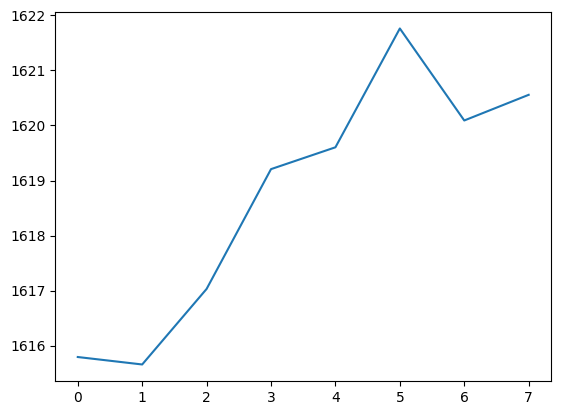

In [ ]:
main()
# it takes about 15 minutes.